In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from functools import partial
from collections import defaultdict
import json
%matplotlib inline

In [2]:
expname = "./output/manual_active_2000_run{}/result.json"

In [3]:
def get_result_per_stage(expname, result_name, runs, jitter=0):
    res = []
    for i in range(1,runs+1):
        with open(Path(expname(i)),'r') as fp:
            data = json.load(fp)
            res.append(data[result_name])
    y = np.asarray(res)
    x = np.asarray(range(5000,5000*5+1,5000))
    if jitter>0:
        x = x + (0.5-np.random.rand(x.shape[0]))*jitter
    return x, y.mean(axis=0), y.std(axis=0)

In [4]:
def get_average_results_per_stage(expname, result_name, runs, stages=5, last_n = 10):
    res = [[] for i in range(stages)]
    for i in range(1,runs+1):
        with open(Path(expname(i)),'r') as fp:
            data = json.load(fp)
            for s in range(stages):
                res[s].extend(data[result_name.format(s)][-last_n:])
    y = np.asarray(res).transpose()
    x = np.asarray(range(5000,5000*5+1,5000))
    print(x,y.shape)
    return x, y.mean(axis=0), y.std(axis=0)

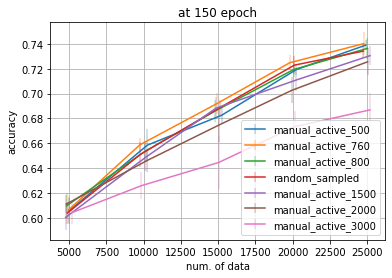

In [161]:
exps = ["manual_active_500", "manual_active_760", "manual_active_800", "random_sampled", "manual_active_1500", "manual_active_2000", "manual_active_3000"]
fmt =  "./output/{}_run{}/result.json"
for expname in exps:
    fnc = partial(fmt.format, expname)
    x,y,d = get_result_per_stage(fnc, 'test_acc_per_stage', 10, jitter=500)
    handle = plt.errorbar(x,y,d,label=expname)
    for b in handle[2]: b.set_alpha(0.3)
plt.legend()
plt.grid()
plt.xlabel('num. of data')
plt.ylabel('accuracy')
plt.title('at 150 epoch')
plt.savefig('./last_test_acc_avg_over_10_exp.png', dpi=300, bbox_inch='tight')

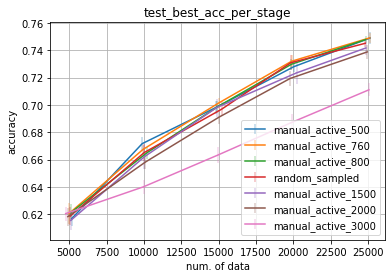

In [162]:
title = "test_best_acc_per_stage"
for expname in exps:
    fnc = partial(fmt.format, expname)
    x,y,d = get_result_per_stage(fnc, title, 10,jitter=500)
    handle = plt.errorbar(x,y,d,label=expname)
    for b in handle[2]: b.set_alpha(0.3)
    
plt.legend()
plt.grid()
plt.xlabel('num. of data')
plt.ylabel('accuracy')
plt.title(title)
plt.savefig(f'./{title}_over_10_exp.png', dpi=300, bbox_inch='tight')

[ 5000 10000 15000 20000 25000] (100, 5)
[ 5000 10000 15000 20000 25000] (100, 5)
[ 5000 10000 15000 20000 25000] (100, 5)
[ 5000 10000 15000 20000 25000] (100, 5)
[ 5000 10000 15000 20000 25000] (100, 5)
[ 5000 10000 15000 20000 25000] (100, 5)


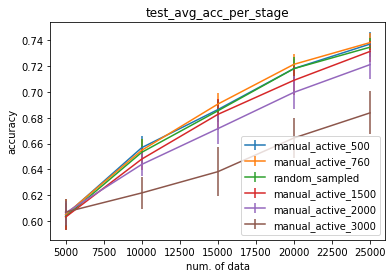

In [121]:
title = "test_avg_acc_per_stage"
for expname in exps:
    fnc = partial(fmt.format, expname)
    result_name = "stage{}_test_accuracy"
    x,y,d = get_average_results_per_stage(fnc,result_name, 10, stages=5, last_n=10)
    plt.errorbar(x,y,d,label=expname)
plt.legend()
plt.xlabel('num. of data')
plt.ylabel('accuracy')
plt.title(title)
plt.savefig(f'./{title}_over_10_exp.png', dpi=300, bbox_inch='tight')

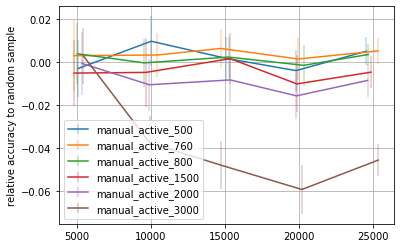

In [147]:
title = "test_best_acc_per_stage"
xd,yd,dd= [defaultdict(list) for i in range(3)]

for expname in exps:
    fnc = partial(fmt.format, expname)
    x,y,d = get_result_per_stage(fnc, title, 10, jitter=True)
    xd[expname] = x
    yd[expname] = y
    dd[expname] = d

for expname in exps:
    if expname == 'random_sampled': continue
    y = (yd[expname]-yd['random_sampled'])
    err = np.sqrt(dd[expname]*dd[expname]+dd['random_sampled']*dd['random_sampled'])
    z = y/yd['random_sampled']
    err = z*(err/y - dd['random_sampled']/yd['random_sampled'])
    handle = plt.errorbar(xd[expname], z, err, label=expname)
    for b in handle[2]: b.set_alpha(0.3)
plt.legend()
plt.grid()
plt.ylabel('relative accuracy to random sample')
plt.savefig('./relative_best_acc.png', dpi=300, nnbox_inch='tight')

In [163]:

import json
import torch, torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from tqdm.notebook import tqdm
from tensorboardX import SummaryWriter
import argparse
import numpy as np
import collections
import itertools as its

from dataset_utils import *
from procedure import train, test
%reload_ext autoreload
%autoreload 2

In [183]:
# setup cifar10 data
bsz = 128
target_mapping = {0:0, 1:1, 2:2, 3:4, 4:3, 5:4, 6:4, 7:4, 8:4, 9:4}
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

tt_train_set = TargetTransformDataset(train_set, target_mapping=target_mapping)

train_sampler = StatefulDataSampler(tt_train_set)
#classes = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
sample_sz = 20
train_sampler.add_samples(dict(zip(range(5), its.repeat(sample_sz))))

Files already downloaded and verified


True

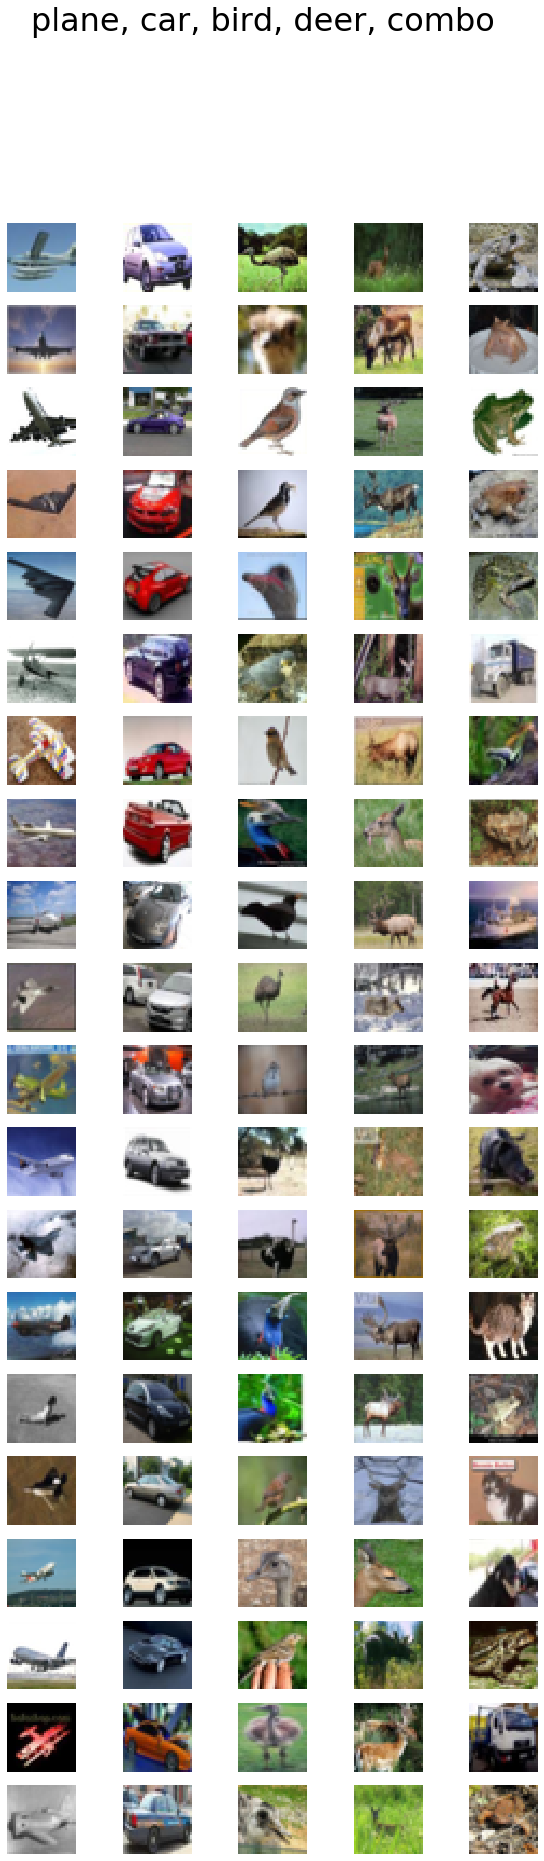

In [196]:
fig, axes = plt.subplots(sample_sz,5,figsize=(10,sample_sz*3//2))
axes = axes.transpose().flatten()
data = collections.defaultdict(list)
for idx in train_sampler.get_samples():
    data[tt_train_set[idx][1]].append(tt_train_set[idx][0])
for ax, img in zip(axes, its.chain(*(data[i] for i in range(5)))):
    ax.imshow(img)
    ax.set_axis_off()
fig.suptitle('plane, car, bird, deer, combo',fontsize=32)
fig.savefig('./train_samples.png', dpi=300, nbox_inch='tight')

In [12]:
tmp = !(ls output | head -n 1)
print(tmp)

['acc_per_class_manual_active_1000_run1']


In [71]:
## New Ver.
def get_result_per_stage(expname, result_name, runs, jitter=0):
    res = []
    for i in range(1,runs+1):
        with open(Path(expname(i)),'r') as fp:
            data = json.load(fp)
            res.append(data[result_name])
    y = np.asarray(res)
    x = np.asarray(range(5000,5000*5+1,5000))
    if jitter>0:
        x = x + (0.5-np.random.rand(x.shape[0]))*jitter
    return x, y.mean(axis=0), y.std(axis=0)

def get_average_results_per_stage(expname, result_name, runs, stages=5, last_n = 10):
    res = [[] for i in range(stages)]
    for i in range(1,runs+1):
        with open(Path(expname(i)),'r') as fp:
            data = json.load(fp)
            for s in range(stages):
                data_s = data[result_name.format(s)][-last_n:]
                res[s].extend(data_s)
    y = np.asarray(res)
    x = np.asarray(range(5000,5000*5+1,5000))
    return x, y.mean(axis=1), y.std(axis=1)

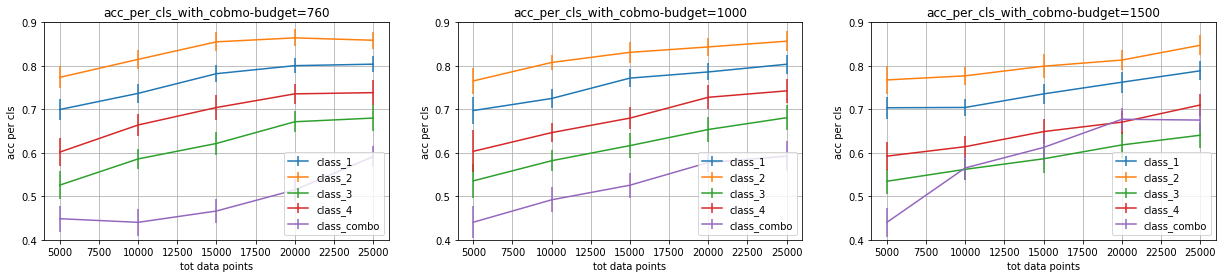

In [117]:
exp_name = 'output/acc_per_class_manual_active_{}_run{}/result.json'
combo_budget=[760, 1000, 1500]
tot_runs = 15

###>>>==============================<<<###

fig, axes = plt.subplots(1, len(combo_budget), figsize=(7*len(combo_budget), 4))
axes = axes.flatten()
for cb, ax in zip(combo_budget, axes):
    tmp_name = partial(exp_name.format, cb)
    rst = get_average_results_per_stage(tmp_name, 'stage_{}_test_acc_per_class', tot_runs, stages=5, last_n = 5)
    for y, dy, c in zip(rst[1].transpose(), rst[2].transpose(), ['1', '2', '3', '4', 'combo']):
        ax.errorbar(rst[0], y, dy/2, label='class_{}'.format(c))
    ax.legend()
    ax.grid()
    ax.set_ylim([0.4, 0.9])
    ax.set_title('acc_per_cls_with_cobmo-budget={}'.format(cb))
    ax.set_ylabel('acc per cls')
    ax.set_xlabel('tot data points')
fig.savefig('./acc_per_cls.png', dpi=300, bbox_inc='tight')

[0.60977333 0.64834133 0.68581867 0.71729867 0.734456  ]
[0.60837867 0.65060267 0.68497867 0.71772    0.73516   ]
[0.60768    0.64456533 0.67644267 0.70830933 0.73234933]


(0.6, 0.75)

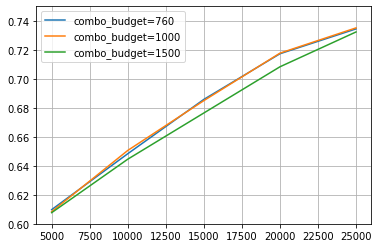

In [104]:
## overall test acc
###>>>==============================<<<###
for cb in combo_budget:
    tmp_name = partial(exp_name.format, cb)
    rst = get_average_results_per_stage(tmp_name, 'stage_{}_test_acc_per_class', tot_runs, stages=5, last_n=5)
    plt.plot(rst[0], rst[1].mean(axis=1), label="combo_budget={}".format(cb))
plt.legend()
plt.grid()
plt.ylim([0.60,0.75])

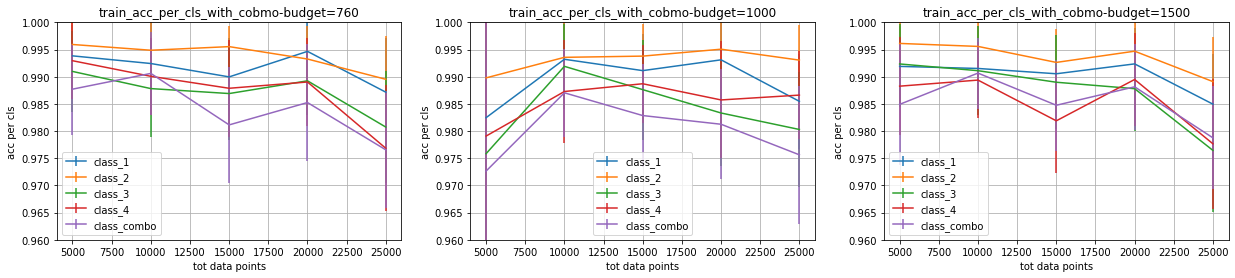

In [120]:
## train acc per cls
###>>>==============================<<<###

fig, axes = plt.subplots(1, len(combo_budget), figsize=(7*len(combo_budget), 4))
axes = axes.flatten()
for cb, ax in zip(combo_budget, axes):
    tmp_name = partial(exp_name.format, cb)
    rst = get_average_results_per_stage(tmp_name, 'stage_{}_train_acc_per_class', tot_runs, stages=5, last_n = 5)
    for y, dy, c in zip(rst[1].transpose(), rst[2].transpose(), ['1', '2', '3', '4', 'combo']):
        ax.errorbar(rst[0], y, dy/2, label='class_{}'.format(c))
    ax.legend()
    ax.grid()
    ax.set_ylim([0.96, 1.0])
    ax.set_title('train_acc_per_cls_with_cobmo-budget={}'.format(cb))
    ax.set_ylabel('acc per cls')
    ax.set_xlabel('tot data points')
#fig.savefig('./acc_per_cls.png', dpi=300, bbox_inc='tight')

## Inverse Accuracy Learning

with data augmentation turned on.

In [134]:
exp_fmt = "./output/acc_per_class_manual_active_with_data_aug_{}_run{}/result.json"

In [135]:
main_rst_tracker = defaultdict(list)

In [136]:
from collections import defaultdict

def get_average_results_per_stage(expname, result_name, runs, stages=5, last_n = 10):
    res = [[] for i in range(stages)]
    for i in range(1,runs+1):
        with open(Path(expname(i)),'r') as fp:
            data = json.load(fp)
            for s in range(stages):
                data_s = data[result_name.format(s)][-last_n:]
                res[s].extend(data_s)
    y = np.asarray(res)
    x = np.asarray(range(5000,5000*5+1,5000))
    return x, y.mean(axis=1), y.std(axis=1)



def get_sample_plan_per_stage(expname, runs, stages=5):
    result_name='stage_{}_sample_plan'
    res = [[] for _ in range(stages)]
    for i in range(1,runs+1):
        with open(Path(expname(i)),'r') as fp:
            data = json.load(fp)
            for s in range(stages):
                data_s = data[result_name.format(s)]
                if isinstance(data_s, dict):
                    ans = [data_s[k] for k in sorted(data_s.keys())]
                else:
                    ans = data_s
                res[s].append(ans)
    return np.asarray(res)
    
                    
def get_result_per_stage(expname, result_name, runs, stages=5, collector='list'):
    if collector=='list':
        res = [[] for i in range(stages)]
    elif collector=='dict':
        res = defaultdict(list)
    
    for i in range(1,runs+1):
        with open(Path(expname(i)),'r') as fp:
            data = json.load(fp)
            for s in range(stages):
                data_s = data[result_name.format(s)]
                print(type(data_s))
                if isinstance(data_s, float):
                    res[s].append(data_s)
                elif isinstance(data_s, dict):
                    for k,v in data_s.items():
                        res[k].append(v)
                else:
                    print(f"error type(data_s) = {type(data_s)}")
                    

            
            
        
    x = np.asarray(range(5000,5000*5+1,5000))
    if jitter>0:
        x = x + (0.5-np.random.rand(x.shape[0]))*jitter
    return x, y.mean(axis=0), y.std(axis=0)

Text(0.5, 1.0, 'test_acc')

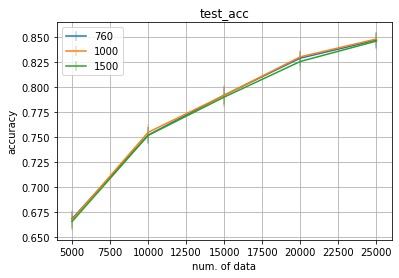

In [137]:
## plot avg acc in one figure
exps = [760, 1000, 1500]

for expname in exps:
    fnc = partial(exp_fmt.format, expname)
    x,y,d = get_average_results_per_stage(fnc, 'stage_{}_test_acc', 15)
    handle = plt.errorbar(x,y,d,label=expname)
    main_rst_tracker[expname] = y
    for b in handle[2]: b.set_alpha(0.3)
plt.legend()
plt.grid()
plt.xlabel('num. of data')
plt.ylabel('accuracy')
plt.title('test_acc')
#plt.savefig('./last_test_acc_avg_over_10_exp.png', dpi=300, bbox_inch='tight')

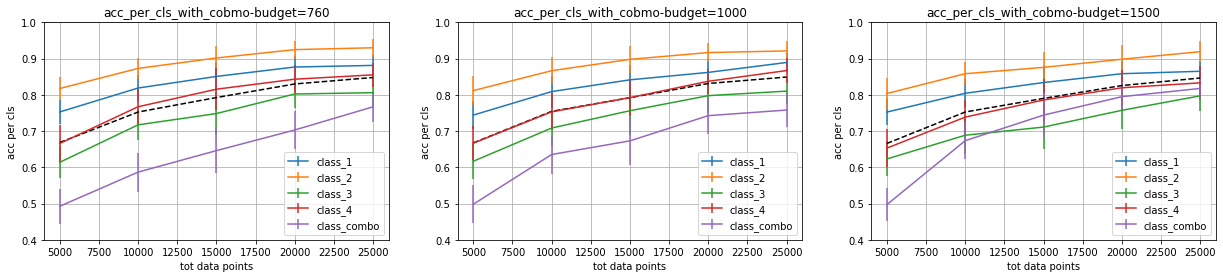

In [138]:
## plot test acc per class in one figure
exps = combo_budget = [760, 1000, 1500]
fig, axes = plt.subplots(1, len(combo_budget), figsize=(7*len(combo_budget), 4))
axes = axes.flatten()
for cb, ax in zip(combo_budget, axes):
    fnc = partial(exp_fmt.format, cb)
    rst = get_average_results_per_stage(fnc, 'stage_{}_test_acc_per_class', 15, stages=5, last_n = 5)
    for y, dy, c in zip(rst[1].transpose(), rst[2].transpose(), ['1', '2', '3', '4', 'combo']):
        ax.errorbar(rst[0], y, dy, label='class_{}'.format(c))
    ax.plot(rst[0], rst[1].transpose().mean(axis=0), 'k--')
    main_rst_tracker[cb-1000] = rst[1].transpose().mean(axis=0)
    ax.legend()
    ax.grid()
    ax.set_ylim([0.4, 1.0])
    ax.set_title('acc_per_cls_with_cobmo-budget={}'.format(cb))
    ax.set_ylabel('acc per cls')
    ax.set_xlabel('tot data points')
#plt.savefig('./last_test_acc_avg_over_10_exp.png', dpi=300, bbox_inch='tight')

In [139]:
exp_fmt = "./output/active_inverse_accuracy_with_data_aug_run{}/result.json"

Text(0.5, 0, 'tot data points')

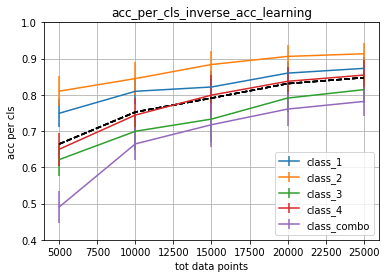

In [140]:
fnc = partial(exp_fmt.format)
rst = get_average_results_per_stage(fnc, 'stage_{}_test_acc_per_class', 15, stages=5, last_n = 5)
fig, ax = plt.subplots(1,1)
for y, dy, c in zip(rst[1].transpose(), rst[2].transpose(), ['1', '2', '3', '4', 'combo']):
    ax.errorbar(rst[0], y, dy, label='class_{}'.format(c))
    ax.plot(rst[0], rst[1].transpose().mean(axis=0), 'k--')
    main_rst_tracker['active'] = rst[1].transpose().mean(axis=0)
ax.legend()
ax.grid()
ax.set_ylim([0.4, 1.0])
ax.set_title('acc_per_cls_inverse_acc_learning')
ax.set_ylabel('acc per cls')
ax.set_xlabel('tot data points')

Text(0.5, 0, 'tot data points')

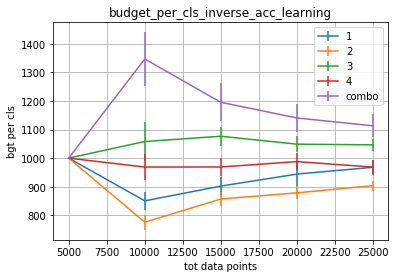

In [141]:
## Plot the budget per cls
fnc = partial(exp_fmt.format)
rst = get_sample_plan_per_stage(fnc, 15, stages=5)
#print(rst.shape, rst[0].shape, rst[0][0].shape)
#print(rst.mean(axis=1))
rst_x  = np.asarray(range(5000,5000*5+1,5000))
rst_m, rst_d = rst.mean(axis=1), rst.std(axis=1)
fig, ax = plt.subplots(1,1)
for y, dy, c in zip(rst_m.transpose(), rst_d.transpose(), ['1', '2', '3', '4', 'combo']):
    ax.errorbar(rst_x, y, dy, label='{}'.format(c))
ax.legend()
ax.grid()
ax.set_title('budget_per_cls_inverse_acc_learning')
ax.set_ylabel('bgt per cls')
ax.set_xlabel('tot data points')

Text(0.5, 1.0, 'relative to random')

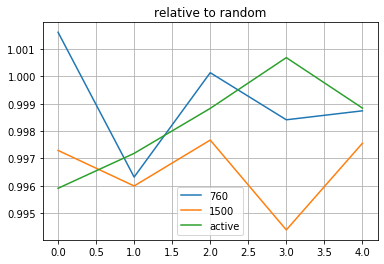

In [145]:
## Plot the main_rst_tracker
print(main_rst_tracker.keys())
for k in [760, 1500, 'active']:
    plt.plot(main_rst_tracker[k]/main_rst_tracker[1000], label=str(k))
plt.grid()
plt.legend()
plt.title('relative to random')


In [161]:
## Comparing inverse accuracy and inverse accuracy to some power
from tabulate import tabulate
samples_y = []
def get_samples(acc, pw=1, tot=1000):
    x = np.asarray(acc)
    y = np.power((1/x), pw)
    return np.floor(y/y.sum()*tot)

acc = 0.1*np.asarray(range(6,11))
for i in range(1,6): 
    samples_y.append(get_samples(acc,pw=i, tot=5000))
    
print(tabulate(zip(acc, *samples_y), headers=["acc", *[f"pw{x}" for x in range(1,6)]]))
print(f"----------------\n")


  acc    pw1    pw2    pw3    pw4    pw5
-----  -----  -----  -----  -----  -----
  0.6   1290   1612   1950   2290   2618
  0.7   1106   1184   1228   1236   1211
  0.8    968    906    822    724    621
  0.9    860    716    577    452    344
  1      774    580    421    296    203
----------------



In [157]:
exp_fmt="./output/active_inverse_accuracy_with_data_aug_pw3_run{}/result.json"

Text(0.5, 0, 'tot data points')

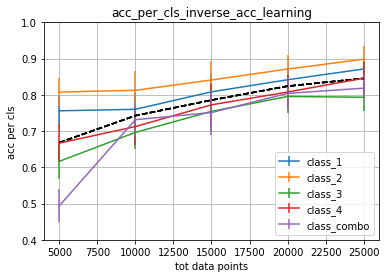

In [158]:
fnc = partial(exp_fmt.format)
rst = get_average_results_per_stage(fnc, 'stage_{}_test_acc_per_class', 11, stages=5, last_n = 5)
fig, ax = plt.subplots(1,1)
for y, dy, c in zip(rst[1].transpose(), rst[2].transpose(), ['1', '2', '3', '4', 'combo']):
    ax.errorbar(rst[0], y, dy, label='class_{}'.format(c))
    ax.plot(rst[0], rst[1].transpose().mean(axis=0), 'k--')
    main_rst_tracker['active_pw3'] = rst[1].transpose().mean(axis=0)
ax.legend()
ax.grid()
ax.set_ylim([0.4, 1.0])
ax.set_title('acc_per_cls_inverse_acc_learning')
ax.set_ylabel('acc per cls')
ax.set_xlabel('tot data points')

Text(0.5, 0, 'tot data points')

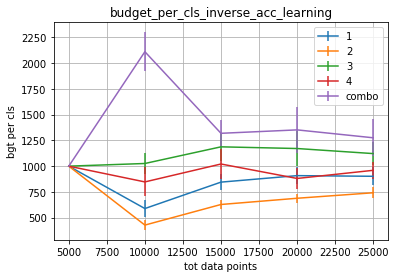

In [159]:
## Plot the budget per cls
fnc = partial(exp_fmt.format)
rst = get_sample_plan_per_stage(fnc, 11, stages=5)
#print(rst.shape, rst[0].shape, rst[0][0].shape)
#print(rst.mean(axis=1))
rst_x  = np.asarray(range(5000,5000*5+1,5000))
rst_m, rst_d = rst.mean(axis=1), rst.std(axis=1)
fig, ax = plt.subplots(1,1)
for y, dy, c in zip(rst_m.transpose(), rst_d.transpose(), ['1', '2', '3', '4', 'combo']):
    ax.errorbar(rst_x, y, dy, label='{}'.format(c))
ax.legend()
ax.grid()
ax.set_title('budget_per_cls_inverse_acc_learning')
ax.set_ylabel('bgt per cls')
ax.set_xlabel('tot data points')

dict_keys([760, 1000, 1500, -240, 0, 500, 'active', 'active_pw3'])


Text(0.5, 1.0, 'relative to random')

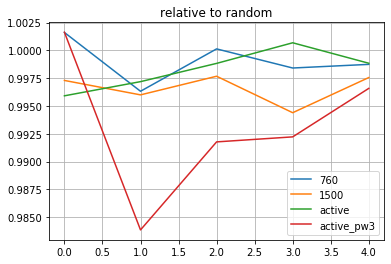

In [163]:
## Plot the main_rst_tracker
print(main_rst_tracker.keys())
for k in [760, 1500, 'active', 'active_pw3']:
    plt.plot(main_rst_tracker[k]/main_rst_tracker[1000], label=str(k))
plt.grid()
plt.legend()
plt.title('relative to random')
